In [207]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.fft import fft as FFT
from scipy import signal

In [3]:
# Define data path
data_file = './../input/UCLA_data/CSC4.Ncs'
# Header has 16 kilobytes length
header_size   = 16 * 1024
# Open file
fid = open(data_file, 'rb')
# Skip header by shifting position by header size
fid.seek(header_size)
# Read data according to Neuralynx information
data_format = np.dtype([('TimeStamp', np.uint64),
                        ('ChannelNumber', np.uint32),
                        ('SampleFreq', np.uint32),
                        ('NumValidSamples', np.uint32),
                        ('Samples', np.int16, 512)])
raw = np.fromfile(fid, dtype=data_format)
# Close file
fid.close()
# Get sampling frequency
sf = raw['SampleFreq'][0]
# Create data vector
data = raw['Samples'].ravel()

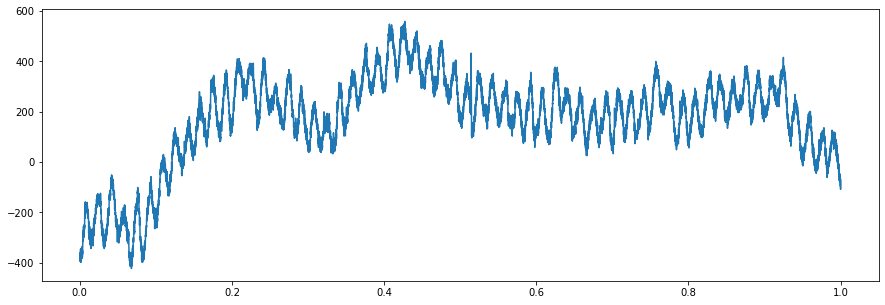

In [173]:
duration = len(data)/sf

full_time = np.linspace(0, duration, len(data))

fig,ax=plt.subplots()
fig.set_size_inches(15,5)
ax.plot(full_time[:sf],data[:sf])

In [204]:
def compute_autocorrelation(y, sf):
    
    acorr = np.correlate(y,y,mode='full')
    acorr = acorr[len(acorr)//2:]
    acorr = acorr/np.max(acorr)
    
    T = 1.0/sf
    x = np.array( [T*i for i in range(0,len(y))])
    
    return x, acorr
    
    
def compute_fft(y, sample_frequency):
    
    T = 1.0/sample_frequency
    N = len(y)
    
    yf = FFT(y)
    xf = np.linspace(0, 1.0 / (2.0*T), N//2)
    
    res = (2.0/(1.0*N)) * np.abs(yf[0:N//2])
    
    return xf, res

def plot_fft(y, 
             sample_frequency,
             xlim = [0,120], 
             ax   = None,
             color = 'black'):
    """
    Plot the FULL fft of the input data
    
    signal           : np array of the signal to plot
    sample_frequency : number of samples per second
    
    Returns:
    ---------
    xf : frequencies of the FFT
    yf : The power density (FFT)
    ax : plot axis
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    xf, power = compute_fft(y, sample_frequency)
    
    ax.plot(xf,power, lw=1, ls ='-', color =color)
    ax.set_xlim(xlim)
    select = (xf >= xlim[0]) & (xf<=xlim[1])
    ax.set_ylim(np.min(power[select]), np.max(power[select]))
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    
    return xf, power, ax


def compute_power(y,sf,nperseg=2048):
    
    f, power = signal.welch(y, fs = sf, 
                             window='hanning', 
                             nperseg=nperseg,
                             scaling='spectrum')
   
    return f, power
    
def plot_power(y, sf, xlim=[0,120], 
                      ax = None, 
                      nperseg=2048,
                      color = 'black'):
    """
    Plots the Welch power spectrum density
    """
    
    if ax is None:
        fig,ax=plt.subplots()
        
    f, power = compute_power(y, sf, nperseg=nperseg) 

    ax.plot(f, power, lw = 1, color = color)
    ax.set_xlim(xlim)
    select = (f >= xlim[0]) & (f<=xlim[1])
    ax.set_ylim(np.min(power[select]), np.max(power[select]))
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('PSD [V**2/Hz]')
    
    return f, power, ax


def downsample(y, sf, target_sf):
    """
    Downsample data
    """
    factor = int(sf / target_sf)
    
    if factor <= 10:
        new_signal = signal.decimate(y,factor)
        sf = int(sf / factor)
    else:
        factor = 10
        new_signal = y
        while factor > 1:
            new_signal = signal.decimate(new_signal, factor)
            sf     = int(sf / factor)
            factor = int(min([10,sf/target_sf]))
    
    return new_signal, sf




def filter_data(y, sf, low=500, high = 9000, order=2):
    """
    Highpass filter designed to capture the spikes 
    
    """
    nyq = sf / 2
     
    low   = low/nyq
    high  = high/nyq
    
    b,a = signal.butter(order, [low,high], btype='band')
    
    filtered = signal.filtfilt(b,a,y)
    
    return filtered



def filter_freq(y, sf, f0 = 60.0, Q = 30):
    """
    Filter out a 60 Hz signal
    """
    
    b,a = signal.iirnotch(f0, Q,sf)
    
    return signal.filtfilt(b,a,y)
    
    

[]

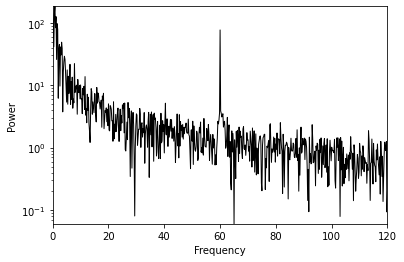

In [51]:
xf,yf,ax = plot_fft(data[:sf*5],sf)
ax.semilogy()

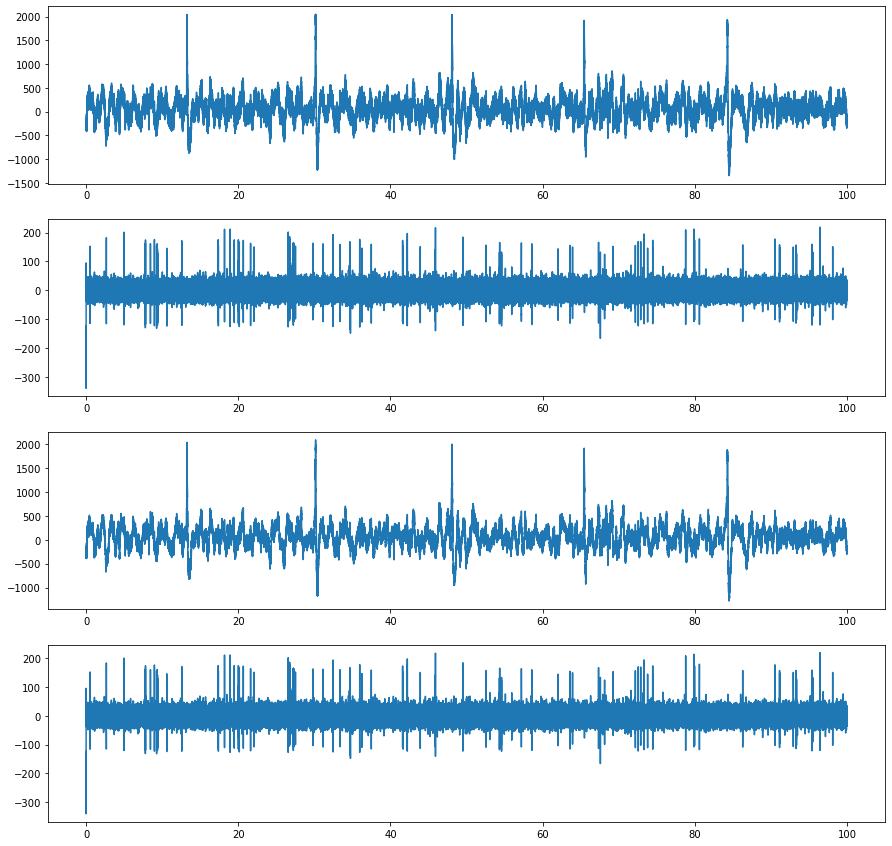

In [104]:
n = 100
y = data[:sf*n]
x = time[:sf*n]

high_signal  = filter_data(y, sf)
clean_signal = filter_freq(y, sf, f0=60.0)


fig, ax=plt.subplots(4,1)
fig.set_size_inches(15,15)

ax[0].plot(x, y)
ax[1].plot(x, high_signal)
ax[2].plot(x, clean_signal)

ax[3].plot(x, filter_freq(high_signal,sf,f0=60))


# Low Pass Filtering

Perform an analysis of the low frequency data here (< 300 Hz in this case). 

(-300.0, 400.0)

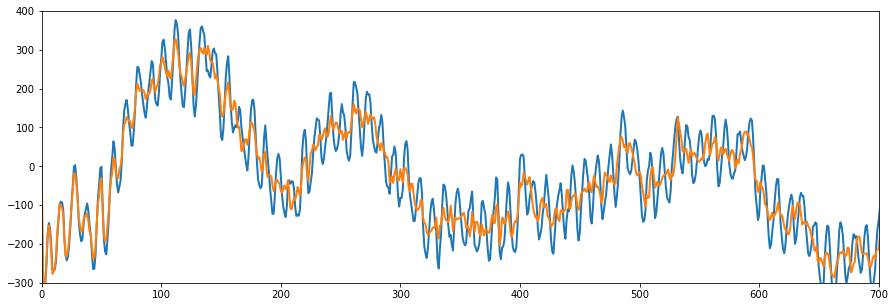

In [94]:
#
#
# Explore the low signal regime here
#
#
low_freq  = 1.0
high_freq = 300.0

lfp_signal         = filter_data(data, sf, low=low_freq,high=high_freq)
lfp_signal, sf_lfp = downsample(lfp_signal, sf, high_freq*2)

clean_lfp = filter_freq(lfp_signal, sf_lfp)

fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(lfp_signal,lw = 2)
ax.plot(clean_lfp, lw = 2)
ax.set_xlim(0,700)
ax.set_ylim(-300,400)



[]

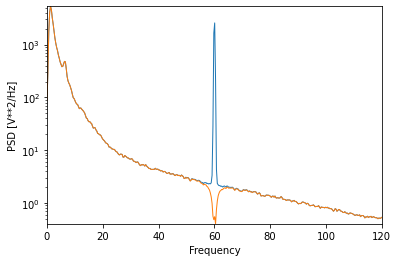

In [103]:
f, power, ax = plot_power(lfp_signal, sf_lfp, color = 'C0')
plot_power(clean_lfp, sf_lfp, color='C1',ax=ax);
ax.semilogy()

In [118]:
def get_spikes(y, 
               spike_window=80, 
               tf=5, 
               offset=10, 
               max_tf=20):
    """
    
    tf     : threshold factor (above mean)
    max_tf : upper limit (reject artifacts)
    """
    
    thresh     = np.mean(np.abs(y)) * tf
    max_thresh = np.mean(np.abs(y)) * max_tf
    
    # threshold positions
    pos = np.where(y > thresh)[0]
    pos = pos[ pos > spike_window ] # cut out any early spikes without enough info
    
    
    # extract spikes
    spike_samp = []
    wave_form  = np.empty([1, spike_window*2])
    
    for i in pos:
        
        if i < len(y) - (spike_window+1):
            tmp_waveform = y[i:i+spike_window*2]
            
            # reject artifacts 
            if np.max(tmp_waveform) < max_thresh:
                
                tmp_samp = np.argmax(tmp_waveform) + i 
                
                # re-center on the maximum and shift by offset
                imin = tmp_samp - (spike_window-offset)
                imax = tmp_samp + (spike_window+offset)
                tmp_waveform = y[imin:imax]
                
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form  = np.append(wave_form, tmp_waveform.reshape(1,spike_window*2),axis=0)
                
    
    # 
    ind = np.where(np.diff(spike_samp) > 1)[0]
    
    return spike_samp[ind], wave_form[ind]
                

(0.0, 100.0)

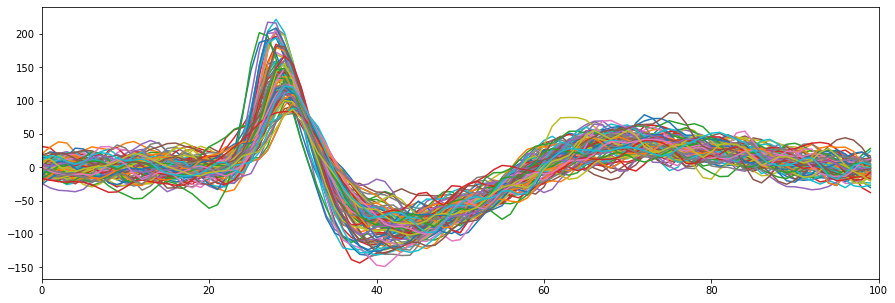

In [121]:
high_signal  = filter_data(data, sf)
spike_samp, wave_form = get_spikes(high_signal, spike_window=50,
                                   tf=8,offset=20)

#
# There are over 2000 spikes
#

np.random.seed(12345)

fig , ax = plt.subplots(figsize=(15,5))

for i in range(100):
    si = np.random.randint(0, len(wave_form))
    ax.plot(wave_form[si,:])

ax.set_xlim(0,100)


# Dimensionality Reduction 

In [224]:
#for i in range(100):
#    si = np.random.randint(0, len(wave_form))
#    plt.plot(scaled[i,:])

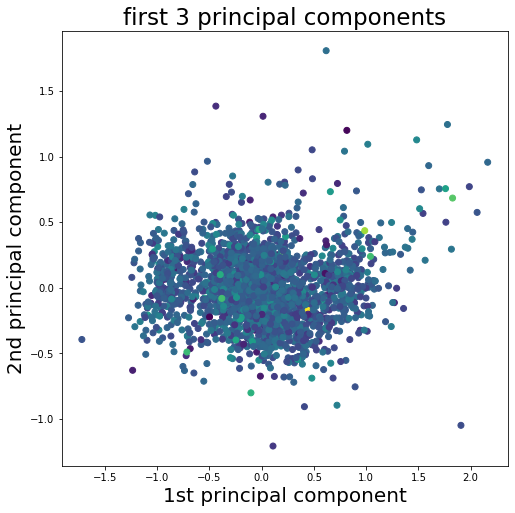

In [125]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# apply min max scaling

scaler = MinMaxScaler()
scaled = scaler.fit_transform(wave_form)

# Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(scaled)
    
# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()   

In [ ]:
for i in range(100):
    si = np.random.randint(0, len(wave_form))
    plt.plot(pca_result[si,:])

In [147]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

res = []
all_n = np.arange(2,20)
for n in all_n:
    kmclf = KMeans(n_clusters=n, random_state=0)
    kmclf.fit(pca_result)
    r = np.sum(np.min(cdist(pca_result, kmclf.cluster_centers_,'euclidean'), axis=1)) / pca_result.shape[0]
    res.append(r)

Text(0, 0.5, 'Distortion')

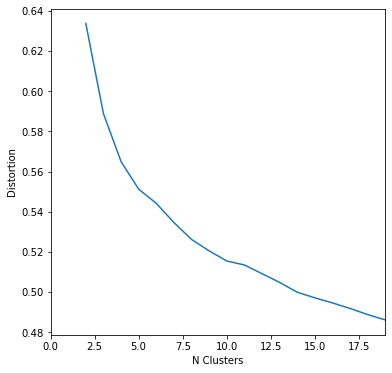

In [149]:
fig,ax =plt.subplots()
fig.set_size_inches(6,6)

ax.plot(all_n, res)
ax.set_xlim(0,max(all_n))
ax.set_xlabel('N Clusters')
ax.set_ylabel('Distortion')

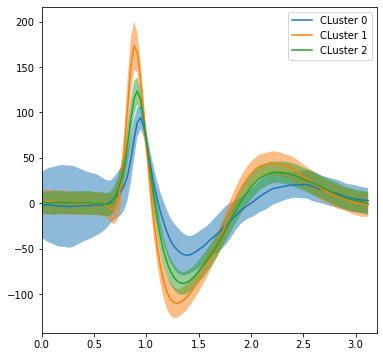

In [160]:
nc=3

kmclf = KMeans(n_clusters=nc, random_state=0)
kmclf.fit(pca_result)

clusters = kmclf.predict(pca_result)

fig,ax = plt.subplots()
fig.set_size_inches(6,6)
time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
for i in range(nc):
    mean = np.mean(wave_form[clusters==i,:], axis=0)
    std =  np.std(wave_form[clusters==i,:], axis=0)
    
    ax.plot(time, mean, label = 'CLuster {}'.format(i))
    ax.fill_between(time, mean-std, mean+std, alpha=0.5)
    
ax.set_xlim(0,3.2)
ax.legend(loc='best')

In [152]:
kmclf.predict

<bound method KMeans.predict of KMeans(n_clusters=6, random_state=0)>

# Other useful things and notes:

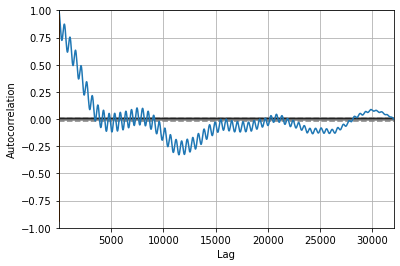

In [189]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data[:sf])

acorr = np.correlate(data[:sf],data[:sf],mode='full')
acorr = acorr[len(acorr)//2:]
acorr = acorr/np.max(acorr)
plt.plot(full_time[:100],acorr[:100])

In [215]:
import detecta

def get_n_peaks(x,y,n):
    """
    Returns the top N peaks.
    """
    
    ind   = detecta.detect_peaks(y)
    
    xp,yp = x[ind], y[ind]
    
    ordered = np.argsort(yp)[::-1] # high to low
    
    return xp[ordered[:n]], yp[ordered[:n]]


def generate_features(sig, sample_freq, npeak=5):
    """
    For a signal, generates features 
    """
    
    def _add_peaks_feature(x,y):
        
        peaks_x, peaks_y = get_n_peaks(x,y,npeak)
        
        return list(peaks_x) + list(peaks_y)
    
    
    xfft, yfft = compute_fft(sig, sample_freq)
    xpow, ypow = compute_power(sig, sample_freq)
    #xacc, yacc = compute_autocorrelation(sig, sample_freq)
    
    features  = _add_peaks_feature(xfft,yfft)
    features += _add_peaks_feature(xpow,ypow)
    #features += _add_peaks_feature(xacc,yacc)
    
    return features

In [216]:
generate_features(clean_lfp, sf_lfp)

[1.149594836729776,
 1.0261237276660202,
 0.9000255737285676,
 1.2483717239807803,
 1.5646679267738905,
 10.37931789612605,
 9.592823334460409,
 9.127280665684438,
 8.794933044092998,
 8.514936434858388,
 1.251953125,
 6.259765625,
 11.8935546875,
 15.33642578125,
 16.9013671875,
 5309.860915109236,
 481.0232691991406,
 63.06625434808264,
 34.76047576514539,
 26.660786281917424]

[]

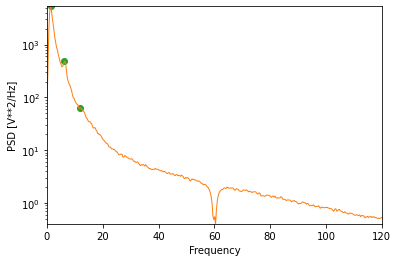

In [202]:
fig,ax=plt.subplots()
xpower, ypower, ax = plot_power(clean_lfp, sf_lfp, color='C1',ax=ax)
xp,yp = get_n_peaks(xpower,ypower,3)
ax.scatter(xp,yp, color = 'C2')
ax.semilogy()